# Autoencoder

Primero quiero ver simplemente el funcionamiento de un autoencoder.

## Preparacion del entorno

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin')
    return dict

Extraemos los datos del fichero.

In [3]:
batch1 = unpickle("Input\cifar-10-batches-py\data_batch_1")
batch2 = unpickle("Input\cifar-10-batches-py\data_batch_2")
batch3 = unpickle("Input\cifar-10-batches-py\data_batch_3")
batch4 = unpickle("Input\cifar-10-batches-py\data_batch_4")
batch5 = unpickle("Input\cifar-10-batches-py\data_batch_5")

En cifar10 los datos estan almacenados en un diccionario que contiene el nombre del lote, las etiquetas para clasificacion, los datos (imagenes) y los nombres de fichero correspondientes.

In [4]:
print(batch1.keys())
for i in batch1:
    print(i, type(batch1[i]))

dict_keys(['batch_label', 'labels', 'data', 'filenames'])
batch_label <class 'str'>
labels <class 'list'>
data <class 'numpy.ndarray'>
filenames <class 'list'>


Las imagenes vienen en el modo ``channelsfirst``, en este modo, tenemos 3 matrices de la dimension de la imagen, una para cada canal. Muchas de las funciones admiten por defecto el modo ``chanelslast`` en el que tenemos una matriz de la dimension de la imagen y cada posicion tiene un vector con los codigos de color de cada punto.

Por simplicidad, como paso de preprocesamiento, voy a transformar las imagenes de ``channelsfirst`` a ``channelslast``.

In [5]:
# https://www.binarystudy.com/2021/09/how-to-load-preprocess-visualize-CIFAR-10-and-CIFAR-100.html
imagen = batch1["data"][0]
imagen = imagen.reshape(3,32,32)
imagen=imagen.transpose(1,2,0)
print(imagen.shape)

(32, 32, 3)


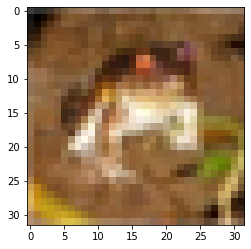

In [6]:
import matplotlib.pyplot as plt
plt.imshow(imagen)

## Preparacion de los datos

Transformo todas las imagenes del lote de ``channelsfirst`` a ``channelslast``.

In [7]:
print(batch1["data"].shape)
X_train = batch1["data"].reshape(10000, 3, 32, 32)
X_train = np.concatenate((X_train, batch2["data"].reshape(10000, 3, 32, 32)))
X_train = np.concatenate((X_train, batch3["data"].reshape(10000, 3, 32, 32)))
X_train = np.concatenate((X_train, batch4["data"].reshape(10000, 3, 32, 32)))
X_train = np.concatenate((X_train, batch5["data"].reshape(10000, 3, 32, 32)))
X_train = X_train.transpose(0,2,3,1)
X_train=X_train/255

(10000, 3072)


(50000, 32, 32, 3)


<Figure size 432x288 with 0 Axes>

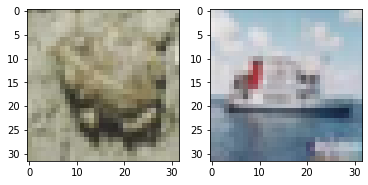

In [8]:
print(X_train.shape)
plt.figure()
f, arrx = plt.subplots(1,2)
arrx[0].imshow(X_train[np.random.randint(0,X_train.shape[0])])
arrx[1].imshow(X_train[np.random.randint(0,X_train.shape[0])])

## Arquitectura del ``Autoencoder``

El ``encoder`` va a ser un modelo basado en ``transfer learning``, vamos a tomar la red de ``mobilenet``, entranada para imagenes de ``imagenet`` sin las capa de clasificacion final, con una entrada de tamaño _img\_shape_ y en el output colocamos la 'representacion latente' una codificacion de la imagen que nos permitiría reconstruirla con un ``decoder``.

In [9]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/preprocess_input
# https://keras.io/guides/transfer_learning/
def build_encoder(dim_latente, img_shape):
    inputs = keras.Input(shape=img_shape)
    x=tf.cast(inputs, tf.float32)
    #x=keras.applications.mobilenet.preprocess_input(x)  #dataformat por defecto es chanel last
    core = keras.applications.MobileNet(input_shape=(img_shape), weights="imagenet", include_top=False)
    #core.trainable = False
    model = core(x, training=False)
    model = keras.layers.GlobalAveragePooling2D()(model)
    repr_latente = keras.layers.Dense(dim_latente)(model)
    return keras.Model(inputs, repr_latente)


Para el ``decoder``, de momento, estoy tomado prestada una arquitectura de un ejemplo de **mrquincle** en github de un ``decoder`` para imagenes de ``MNIST``.

In [10]:
# https://github.com/mrquincle/keras-adversarial-autoencoders/blob/master/Keras%20Adversarial%20Autoencoder%20MNIST.ipynb
def build_decoder(latent_dim, img_shape):
    model = keras.Sequential()
    model.add(keras.layers.Dense(512, input_dim=latent_dim))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dense(512))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dense(np.prod(img_shape), activation='tanh'))
    model.add(keras.layers.Reshape(img_shape))
    z = keras.layers.Input(shape=(latent_dim,))
    img = model(z)
    return keras.Model(z, img)

``Decoder`` alternativo:

In [11]:
def build_myDecoder(dim_latente, img_shape):
    model=keras.Sequential()
    model.add(keras.layers.Dense(512, input_dim=dim_latente))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dense(768, input_dim=dim_latente))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dense(1024, input_dim=dim_latente))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dense(np.prod(img_shape), activation=keras.activations.tanh))
    model.add(keras.layers.Reshape(img_shape))
    z = keras.layers.Input(shape=(dim_latente))
    img =  model(z)
    return keras.Model(z,img)

Construimos la red

In [12]:
img_shape = X_train[0].shape
dim_latente = 20
optimizer = keras.optimizers.Adam(0.0002, 0.5)

encoder = build_encoder(dim_latente, img_shape)
decoder = build_myDecoder(dim_latente, img_shape)
img = keras.layers.Input(img_shape)

encoder_rep = encoder(img)
autoencoder_out = decoder(encoder_rep)

autoencoder = keras.Model(img, autoencoder_out)
autoencoder.compile(loss='mse', optimizer=optimizer, metrics=["accuracy"])

In [13]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.cast (TFOpLambda)        (None, 32, 32, 3)         0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 20)                20500     
                                                                 
Total params: 3,249,364
Trainable params: 3,227,476
Non-train

In [14]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20)]              0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         4340992   
                                                                 
Total params: 4,340,992
Trainable params: 4,340,992
Non-trainable params: 0
_________________________________________________________________


In [15]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 model (Functional)          (None, 20)                3249364   
                                                                 
 model_1 (Functional)        (None, 32, 32, 3)         4340992   
                                                                 
Total params: 7,590,356
Trainable params: 7,568,468
Non-trainable params: 21,888
_________________________________________________________________


## Entrenamiento

Imagenes para muestreo visual

In [16]:
def sample_imgs(dataset, model, epoch, sample_size=5, save_imgs=True):
    # Tomamos sample_size imagenes de muestra
    ids = np.random.randint(0,dataset.shape[0], sample_size)
    sample=dataset[ids]
    # Intentamos regenerar las imagenes
    gen_img = model.predict(sample)
    # Guardamos una grafica con la muestra (arriba) y las imagenes generadas (abajo)
    f, axxs = plt.subplots(2,sample_size)
    for j in range(sample_size):
        axxs[0,j].imshow(sample[j])
        axxs[1,j].imshow(gen_img[j])
    if save_imgs:
        f.savefig("output/autoencoderCIFAR10_e%d.png" % (epoch))
        plt.close()
    

In [17]:
sample_from = unpickle("Input\cifar-10-batches-py\\test_batch")
sample_from = sample_from["data"]
sample_from.shape

(10000, 3072)

In [18]:
sample_from = sample_from.reshape(10000,3,32,32)
sample_from = sample_from.transpose(0,2,3,1)
sample_from = sample_from/255


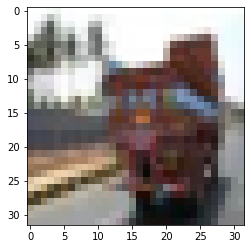

In [19]:
plt.imshow(sample_from[np.random.randint(0,sample_from.shape[0])])

Entrenamiento

In [20]:
# https://github.com/mrquincle/keras-adversarial-autoencoders/blob/master/Keras%20Adversarial%20Autoencoder%20MNIST.ipynb
epochs=10000
batch_size=1000
sample_interval=500

for epoch in range(epochs+1):
    # lote de imagenes
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # entrenamos al autoencoder
    loss = autoencoder.train_on_batch(imgs,imgs)
    
    # monitorizamos el progreso
    if epoch % 10==0:
        print("Epoch: %d loss = %f, acc = %.2f%%" % (epoch, loss[0], 100*loss[1]))
    # Hacemos una muestra visual
    if epoch % sample_interval==0:
        sample_imgs(sample_from, autoencoder, epoch)


Epoch: 0 loss = 0.295470, acc = 33.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 10 loss = 0.067786, acc = 36.95%
Epoch: 20 loss = 0.062500, acc = 40.52%
Epoch: 30 loss = 0.063642, acc = 38.50%
Epoch: 40 loss = 0.062099, acc = 40.89%
Epoch: 50 loss = 0.055004, acc = 42.56%
Epoch: 60 loss = 0.054404, acc = 42.49%
Epoch: 70 loss = 0.051799, acc = 42.02%
Epoch: 80 loss = 0.051031, acc = 43.27%
Epoch: 90 loss = 0.051089, acc = 43.74%
Epoch: 100 loss = 0.059730, acc = 42.81%
Epoch: 110 loss = 0.047619, acc = 42.72%
Epoch: 120 loss = 0.048429, acc = 44.53%
Epoch: 130 loss = 0.055018, acc = 42.75%
Epoch: 140 loss = 0.061128, acc = 44.04%
Epoch: 150 loss = 0.044501, acc = 45.08%
Epoch: 160 loss = 0.046693, acc = 44.78%
Epoch: 170 loss = 0.043988, acc = 44.99%
Epoch: 180 loss = 0.044267, acc = 43.56%
Epoch: 190 loss = 0.043697, acc = 44.21%
Epoch: 200 loss = 0.043521, acc = 44.89%
Epoch: 210 loss = 0.042786, acc = 43.76%
Epoch: 220 loss = 0.055832, acc = 41.25%
Epoch: 230 loss = 0.039488, acc = 45.50%
Epoch: 240 loss = 0.041709, acc = 44.29%
Epoch: 250 loss = 0.04233

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 2500 loss = 0.026381, acc = 57.19%
Epoch: 2510 loss = 0.025072, acc = 58.71%
Epoch: 2520 loss = 0.025596, acc = 56.72%
Epoch: 2530 loss = 0.027589, acc = 58.74%
Epoch: 2540 loss = 0.035176, acc = 52.47%
Epoch: 2550 loss = 0.028315, acc = 57.16%
Epoch: 2560 loss = 0.025203, acc = 58.91%
Epoch: 2570 loss = 0.026412, acc = 58.36%
Epoch: 2580 loss = 0.026552, acc = 56.46%
Epoch: 2590 loss = 0.025293, acc = 58.42%
Epoch: 2600 loss = 0.025086, acc = 61.05%
Epoch: 2610 loss = 0.027587, acc = 57.12%
Epoch: 2620 loss = 0.026082, acc = 59.69%
Epoch: 2630 loss = 0.024683, acc = 59.11%
Epoch: 2640 loss = 0.025179, acc = 59.24%
Epoch: 2650 loss = 0.025737, acc = 57.07%
Epoch: 2660 loss = 0.026676, acc = 57.51%
Epoch: 2670 loss = 0.025948, acc = 59.41%
Epoch: 2680 loss = 0.027169, acc = 57.21%
Epoch: 2690 loss = 0.026004, acc = 59.22%
Epoch: 2700 loss = 0.025585, acc = 57.96%
Epoch: 2710 loss = 0.025089, acc = 56.98%
Epoch: 2720 loss = 0.026730, acc = 57.39%
Epoch: 2730 loss = 0.025766, acc =

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 3010 loss = 0.024239, acc = 58.56%
Epoch: 3020 loss = 0.025310, acc = 57.26%
Epoch: 3030 loss = 0.026496, acc = 58.72%
Epoch: 3040 loss = 0.030733, acc = 58.45%
Epoch: 3050 loss = 0.031974, acc = 55.06%
Epoch: 3060 loss = 0.024730, acc = 57.29%
Epoch: 3070 loss = 0.024118, acc = 58.04%
Epoch: 3080 loss = 0.023914, acc = 58.89%
Epoch: 3090 loss = 0.024472, acc = 58.04%
Epoch: 3100 loss = 0.024448, acc = 59.69%
Epoch: 3110 loss = 0.024356, acc = 59.37%
Epoch: 3120 loss = 0.023650, acc = 54.66%
Epoch: 3130 loss = 0.023955, acc = 58.71%
Epoch: 3140 loss = 0.025985, acc = 56.00%
Epoch: 3150 loss = 0.024895, acc = 59.21%
Epoch: 3160 loss = 0.024258, acc = 58.59%
Epoch: 3170 loss = 0.023777, acc = 58.77%
Epoch: 3180 loss = 0.023650, acc = 57.98%
Epoch: 3190 loss = 0.024047, acc = 59.12%
Epoch: 3200 loss = 0.025056, acc = 59.91%
Epoch: 3210 loss = 0.023338, acc = 59.97%
Epoch: 3220 loss = 0.023989, acc = 57.16%
Epoch: 3230 loss = 0.024872, acc = 58.65%
Epoch: 3240 loss = 0.024357, acc =

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 3500 loss = 0.023783, acc = 57.73%
Epoch: 3510 loss = 0.024696, acc = 55.24%
Epoch: 3520 loss = 0.026915, acc = 54.35%
Epoch: 3530 loss = 0.026379, acc = 58.42%
Epoch: 3540 loss = 0.023535, acc = 56.59%
Epoch: 3550 loss = 0.022584, acc = 58.84%
Epoch: 3560 loss = 0.023069, acc = 60.08%
Epoch: 3570 loss = 0.023246, acc = 57.23%
Epoch: 3580 loss = 0.023445, acc = 57.72%
Epoch: 3590 loss = 0.023451, acc = 59.80%
Epoch: 3600 loss = 0.023074, acc = 58.75%
Epoch: 3610 loss = 0.024692, acc = 58.61%
Epoch: 3620 loss = 0.030405, acc = 58.09%
Epoch: 3630 loss = 0.031686, acc = 58.49%
Epoch: 3640 loss = 0.025896, acc = 56.63%
Epoch: 3650 loss = 0.023456, acc = 57.03%
Epoch: 3660 loss = 0.023125, acc = 58.52%
Epoch: 3670 loss = 0.023125, acc = 59.86%
Epoch: 3680 loss = 0.022285, acc = 57.50%
Epoch: 3690 loss = 0.022532, acc = 59.49%
Epoch: 3700 loss = 0.023534, acc = 58.19%
Epoch: 3710 loss = 0.023317, acc = 59.10%
Epoch: 3720 loss = 0.022805, acc = 59.01%
Epoch: 3730 loss = 0.022737, acc =

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 7500 loss = 0.020500, acc = 59.24%
Epoch: 7510 loss = 0.019735, acc = 60.42%
Epoch: 7520 loss = 0.019930, acc = 59.67%
Epoch: 7530 loss = 0.020059, acc = 59.78%
Epoch: 7540 loss = 0.020445, acc = 59.99%
Epoch: 7550 loss = 0.020178, acc = 59.96%
Epoch: 7560 loss = 0.020648, acc = 59.58%
Epoch: 7570 loss = 0.020342, acc = 59.07%
Epoch: 7580 loss = 0.023229, acc = 59.12%
Epoch: 7590 loss = 0.030663, acc = 60.45%
Epoch: 7600 loss = 0.023004, acc = 59.95%
Epoch: 7610 loss = 0.020144, acc = 59.52%
Epoch: 7620 loss = 0.019792, acc = 59.50%
Epoch: 7630 loss = 0.020120, acc = 60.53%
Epoch: 7640 loss = 0.020567, acc = 60.06%
Epoch: 7650 loss = 0.020169, acc = 59.93%
Epoch: 7660 loss = 0.020622, acc = 60.40%
Epoch: 7670 loss = 0.020067, acc = 60.29%
Epoch: 7680 loss = 0.020029, acc = 61.56%
Epoch: 7690 loss = 0.019872, acc = 60.15%
Epoch: 7700 loss = 0.020695, acc = 62.61%
Epoch: 7710 loss = 0.020046, acc = 56.35%
Epoch: 7720 loss = 0.020127, acc = 60.29%
Epoch: 7730 loss = 0.019793, acc =

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 8000 loss = 0.019789, acc = 60.75%
Epoch: 8010 loss = 0.020339, acc = 61.78%
Epoch: 8020 loss = 0.020159, acc = 60.21%
Epoch: 8030 loss = 0.022265, acc = 59.75%
Epoch: 8040 loss = 0.020950, acc = 58.08%
Epoch: 8050 loss = 0.020528, acc = 60.83%
Epoch: 8060 loss = 0.019761, acc = 60.69%
Epoch: 8070 loss = 0.020126, acc = 59.67%
Epoch: 8080 loss = 0.020338, acc = 61.12%
Epoch: 8090 loss = 0.020548, acc = 60.14%
Epoch: 8100 loss = 0.020995, acc = 59.95%
Epoch: 8110 loss = 0.021035, acc = 59.92%
Epoch: 8120 loss = 0.020419, acc = 60.12%
Epoch: 8130 loss = 0.020273, acc = 60.78%
Epoch: 8140 loss = 0.020475, acc = 59.59%
Epoch: 8150 loss = 0.020458, acc = 60.30%
Epoch: 8160 loss = 0.019536, acc = 61.31%
Epoch: 8170 loss = 0.020620, acc = 60.72%
Epoch: 8180 loss = 0.021515, acc = 60.51%
Epoch: 8190 loss = 0.025236, acc = 57.48%
Epoch: 8200 loss = 0.023100, acc = 59.35%
Epoch: 8210 loss = 0.021051, acc = 59.99%
Epoch: 8220 loss = 0.019603, acc = 59.82%
Epoch: 8230 loss = 0.019509, acc =

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 8510 loss = 0.020163, acc = 60.88%
Epoch: 8520 loss = 0.021049, acc = 62.35%
Epoch: 8530 loss = 0.020052, acc = 60.78%
Epoch: 8540 loss = 0.020079, acc = 61.03%
Epoch: 8550 loss = 0.019518, acc = 61.26%
Epoch: 8560 loss = 0.019833, acc = 60.80%
Epoch: 8570 loss = 0.021326, acc = 60.08%
Epoch: 8580 loss = 0.020652, acc = 61.94%
Epoch: 8590 loss = 0.020236, acc = 59.90%
Epoch: 8600 loss = 0.020383, acc = 60.36%
Epoch: 8610 loss = 0.019645, acc = 61.79%
Epoch: 8620 loss = 0.019589, acc = 59.77%
Epoch: 8630 loss = 0.020139, acc = 61.17%
Epoch: 8640 loss = 0.023787, acc = 59.41%
Epoch: 8650 loss = 0.034540, acc = 58.33%
Epoch: 8660 loss = 0.023170, acc = 60.39%
Epoch: 8670 loss = 0.020201, acc = 61.55%
Epoch: 8680 loss = 0.019770, acc = 61.26%
Epoch: 8690 loss = 0.019589, acc = 60.77%
Epoch: 8700 loss = 0.019246, acc = 60.12%
Epoch: 8710 loss = 0.020317, acc = 60.82%
Epoch: 8720 loss = 0.019886, acc = 61.50%
Epoch: 8730 loss = 0.019773, acc = 60.28%
Epoch: 8740 loss = 0.019408, acc =

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 10000 loss = 0.020362, acc = 61.93%


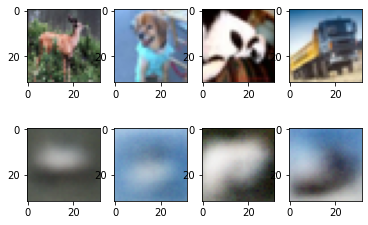

In [28]:
sample_imgs(sample_from, autoencoder, 0, 4, False)


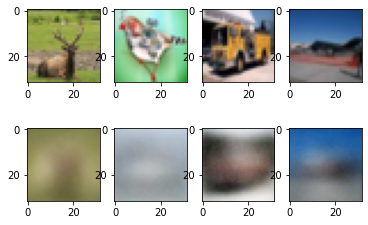

In [31]:
sample_imgs(X_train, autoencoder, 0, 4, False)